<a href="https://colab.research.google.com/github/SebastianOrmaechea/Reinforcement-Learning/blob/main/lab_3_intro_rl_SGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2022



<font color='red'>Integrantes:


<font color='red'> * Garay, Carolina del Valle

<font color='red'> * Ormaechea, Sebastián Gabriel

<font color='red'> * Venchiarutti, Gustavo




## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por
$$\pi(a \mid s) = 1 - \epsilon$$ si $a$ es la mejor acción, caso contrario $$\pi(a \mid s) = \epsilon$$

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/SebastianOrmaechea/Reinforcement-Learning/blob/Lab1_RL_Garay/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/SebastianOrmaechea/Reinforcement-Learning/blob/Lab1_RL_Garay/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, done, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.

* ```seed(self)``` : Establece la semilla aleatoria del generador de números aleatorios del presente entorno.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import gym

In [2]:
#@title Código básico de graficación (no modificar)

def plot_reward_per_episode(reward_ep):

    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

    plt.plot(reward_per_episode)
    plt.title('Recompensa acumulada por episodio')
    plt.show()
    
    
def plot_steps_per_episode(timesteps_ep):
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title('Pasos (timesteps) por episodio')
    plt.show()
    
    
def plot_steps_per_episode_smooth(timesteps_ep):
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [acumulated_steps[i] / episode_number[i] for i in range(len(acumulated_steps))]

    plt.plot(steps_per_episode)
    plt.title('Pasos (timesteps) acumulados por episodio')
    plt.show()
    

def draw_value_matrix(q):

    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):

            state_values = []

            for action in range(n_actions):
                state_values.append(q.get((row * n_columns + column, action), -100))

            maximum_value = max(state_values)  # determinamos la acción que arroja máximo valor


            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar) para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])):

        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = 'D'
        best_action = down_action

        if best_action < right_action:
            arrow_direction = 'R'
            best_action = right_action
        if best_action < left_action:
            arrow_direction = 'L'
            best_action = left_action
        if best_action < up_action:
            arrow_direction = 'U'
            best_action = up_action
        if best_action == -1:
            arrow_direction = ''

        # notar que column, row están invertidos en orden en la línea de abajo porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print('\n Matriz de mejor acción-valor (en números): \n\n', q_value_matrix)

Ejemplo: agente CartPole

In [3]:
import gym
import time
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0')
    env.reset()
    for _ in range(500):
        env.render(mode='human')
        observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [4]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    observation = env.reset()
    for t in range(500):
        env.render(mode='human')
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff. 


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados 
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [5]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]  # ej: para 4 acciones inicializa en [0,0,0,0]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:  # sorteamos un número: es menor a épsilon?
        return random_state.choice(actions)  # sí: se selecciona una acción aleatoria

    count = q_values.count(max_q)

    
    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [6]:
def learn(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    # TODO - completa con tu código aquí
    
    pass

Finalmente, definimos el método principal de iteraciones. 

In [7]:
def run():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    timesteps_of_episode = []  # registro de la cantidad de pasos que le llevó en cada episodio
    reward_of_episode = []  # cantidad de recompensa que recibió el agente en cada episodio

    for i_episode in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo llega a la salida
        # o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual
        action = choose_action(state)
        
        while not done:

            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(next_state)
            

            episode_reward += reward
            learn(state, action, reward, next_state, next_action)

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [8]:
# se crea el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5
gamma = 1
epsilon = 0.1
tau = 25

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Ya instanciado, ejecutamos nuestro agente

In [9]:
avg_steps_per_episode, timesteps_ep, reward_ep = run()

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

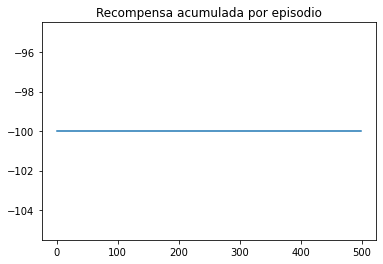

In [10]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

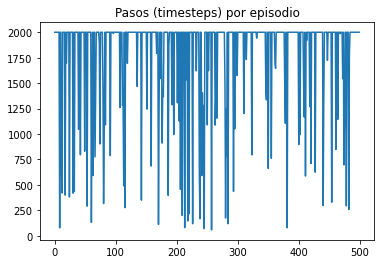

In [11]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

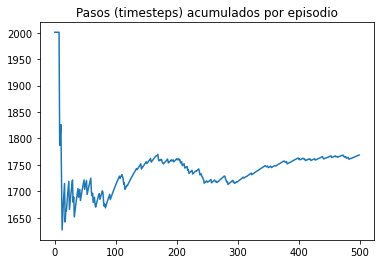

In [12]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

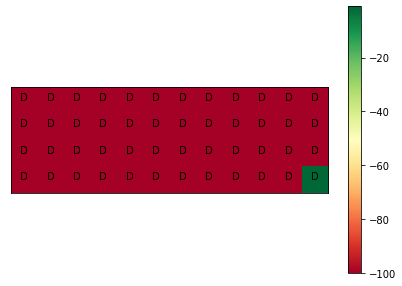


 Matriz de mejor acción-valor (en números): 

 [[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [13]:
draw_value_matrix(q)

In [14]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN

## **Actividades**

### **1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".**


In [15]:
def choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an epsilon-greedy exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]  # ej: para 4 acciones inicializa en [0,0,0,0]
    max_q = max(q_values)

    if random_state.uniform() < epsilon:  # sorteamos un número: es menor a épsilon?
        return random_state.choice(actions)  # sí: se selecciona una acción aleatoria

    count = q_values.count(max_q)

    
    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [16]:
def learnSARSA(state, action, reward, next_state, next_action):
    """
    Performs a SARSA update for a given state transition
    """
    
    # TODO - completa con tu código aquí
    predict = q.get((state, action),0.0)
    target = reward + gamma * q.get((next_state, next_action),0.0) 
    q[(state,action)] = predict + alpha*(target-predict)
    pass

In [17]:
# Creamos el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# Definimos los híper-parámetros básicos según lo observado en clase

alpha = 0.5
gamma = 1
epsilon = 0.1

episodes_to_run = 1000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [18]:
def runSARSA():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        #action = random_state.choice(actions)
        
        while not done:
            #env.render()

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state)
            #next_action = random_state.choice(actions)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learnSARSA(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learnSARSA(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [19]:
# Ejecutamos el agente
avg_steps_per_episode, timesteps_epSARSA, reward_epSARSA = runSARSA()

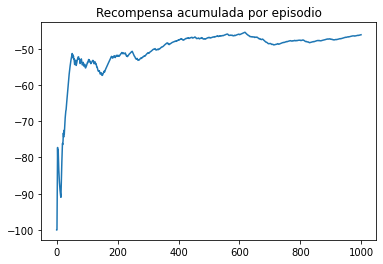

In [20]:
# Ploteamos el reward a lo largo de los episodios en forma acumulada
plot_reward_per_episode(reward_epSARSA)

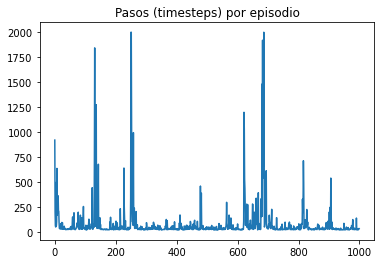

In [21]:
# Ploteamos el reward para cada episodio
plot_steps_per_episode(timesteps_epSARSA)

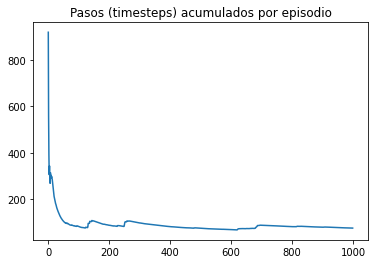

In [22]:
#Graficamos pasos acumulados por episodio
plot_steps_per_episode_smooth(timesteps_epSARSA)

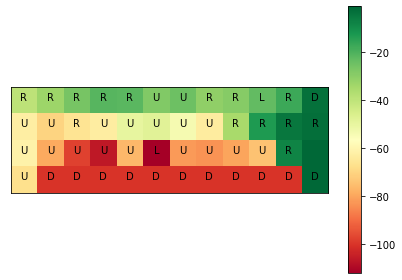


 Matriz de mejor acción-valor (en números): 

 [[ -39.55529554  -32.76135386  -26.49341284  -21.06510959  -21.56786929
   -27.95521467  -24.45074863  -30.5960068   -28.90249051  -22.70571239
   -17.24065579   -3.52082504]
 [ -62.43341198  -70.1454955   -65.96457344  -62.85542156  -49.61054786
   -48.22128226  -53.9050742   -63.44169045  -35.19325173  -12.81358959
    -4.83135929   -3.14953565]
 [ -60.92847518  -79.35662445  -97.59660319 -106.38542087  -76.27318572
  -112.10430498  -82.08194885  -83.42997989  -80.30225371  -74.2305409
    -7.69903085   -1.        ]
 [ -67.3135249  -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [23]:
#Graficamos matriz de acción-valor
draw_value_matrix(q)


### **2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.**


In [24]:
# Creamos el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# Definimos los híper-parámetros básicos según lo observado en clase

alpha = 0.5
gamma = 1
epsilon = 0.1

episodes_to_run = 1000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [25]:
def learnQLEARN(state, action, reward, next_state, next_action):
    """
    Q-learm update for a given state transition
    """
    # TODO - completa con tu código aquí
    predict = q.get((state, action),0.0)
    q_values = [q.get((next_state, a), 0.0) for a in actions]
    max_q = max(q_values)
    target = reward + gamma * max_q #La politica optima de la tabla q para esa accion 
    q[(state,action)] = predict + alpha * (target-predict)
    pass

In [26]:
def runQL():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        #action = random_state.choice(actions)
        
        while not done:
            #env.render()

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state)
            #next_action = random_state.choice(actions)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learnQLEARN(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learnQLEARN(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [27]:
# Ejecutamos el agente
avg_steps_per_episode, timesteps_epQL, reward_epQL = runQL()

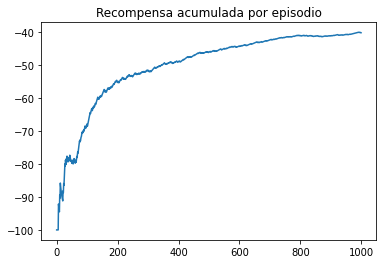

In [28]:
plot_reward_per_episode(reward_epQL)

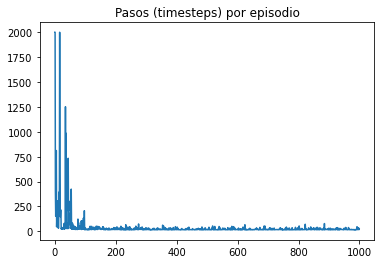

In [29]:
# Ploteamos el reward para cada episodio
plot_steps_per_episode(timesteps_epQL)

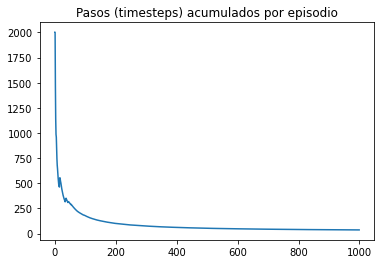

In [30]:
#Ploteamos pasos acumulados por episodio
plot_steps_per_episode_smooth(timesteps_epQL)

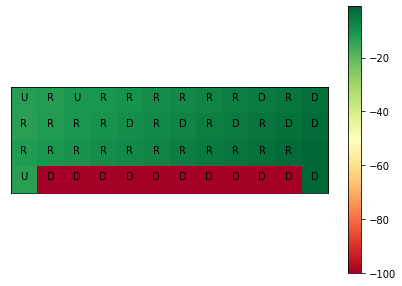


 Matriz de mejor acción-valor (en números): 

 [[ -12.80177639  -12.2702204   -11.27025845  -10.96102835   -9.96854421
    -8.97508123   -7.98078401   -6.98450462   -5.98590219   -4.98612758
    -3.99505804   -3.        ]
 [ -12.9999963   -11.9999963   -10.9999963    -9.99999723   -8.99999815
    -7.99999841   -6.99999855   -5.99999952   -4.99999982   -4.
    -3.           -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [31]:
#Graficamos matriz acción-valor
draw_value_matrix(q)

### Analizamos la convergencia del algoritmo Q-Learning respecto a SARSA

In [32]:
# Primero definimos una función que calcule el reward por episodio
def reward_per_episode(reward_ep):
  ep_rew = np.array(reward_ep)
  ep_num = np.linspace(1, len(ep_rew) + 1, len(ep_rew) + 1 )
  acum_rew = np.cumsum(ep_rew)
  rew_per_ep = [acum_rew[i] / ep_num[i] for i in range(len(acum_rew))]
  return rew_per_ep

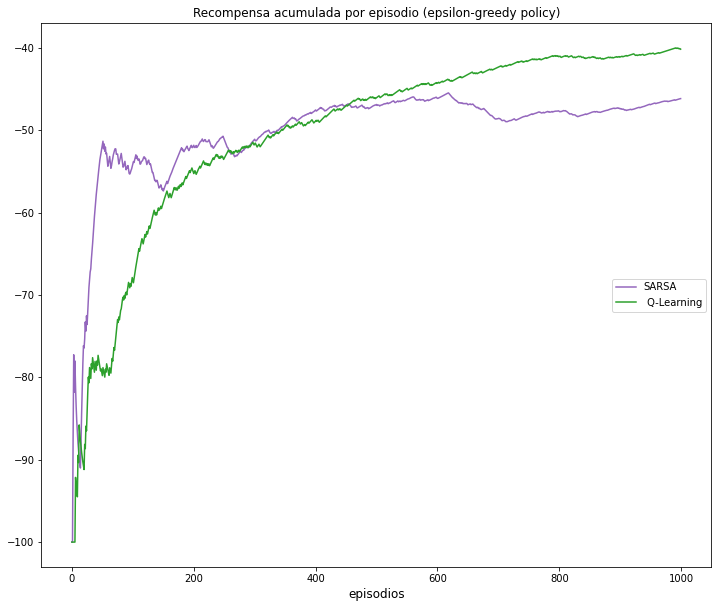

In [33]:
# Realizamos la gráfica que compara la recompensa obtenida para ambos algoritmos.
fig = plt.figure(figsize=(12,10))
fig.clf()
ax = fig.subplots(1,1)
ax.plot(reward_per_episode(reward_epSARSA), color = 'tab:purple', label="SARSA")
ax.plot(reward_per_episode(reward_epQL), color = 'tab:green', label=" Q-Learning")
ax.legend(loc = 'right')
plt.title('Recompensa acumulada por episodio (epsilon-greedy policy)')
plt.xlabel("episodios", size = 12)
plt.show()


Podemos observar que ambos algoritmos alcanzan la convergencia alrededor del episodio 800. Sin embargo, el agente del algoritmo Q-Learning puede acumular más recompensas (aprende una mejor estrategia) a medida que avanza el entrenamiento. Esta mayor acumulación de recompensa ocurre debido a que Q-Learning elige la dirección que maximiza el valor Q(estado,acción) cada vez que se actualiza, y cuando pasa al siguiente estado vuelve a seleccionar la mejor acción posible.
El agente Q-Learning ha aprendido a maximizar la recompensa total obtenida en un episodio al comportarse de manera óptima en cada estado.



### **3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$**


### Definimos nuevos híper-parámetros para evaluar sus resultados en algoritmo SARSA



a.   Variamos sólo $\epsilon$

b.   Variamos $\epsilon$ y $\gamma$



**a. Variamos $\epsilon$ y mantenemos el resto de hiperparámetros con los mismos valores.**

In [34]:
q = {}

alpha = 0.5 # Queda igual
gamma = 1 # Queda igual
epsilon = 0.2 # Antes 0.1

episodes_to_run = 1000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [35]:
def runSARSA_1():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        #action = random_state.choice(actions)
        
        while not done:
            #env.render()

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state)
            #next_action = random_state.choice(actions)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learnSARSA(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learnSARSA(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [36]:
# Ejecutamos el agente
avg_steps_per_episode, timesteps_ep, reward_epSARSA_1 = runSARSA_1()

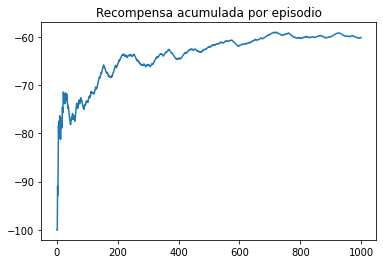

In [37]:
plot_reward_per_episode(reward_epSARSA_1)

### Evaluamos los resultados en algoritmo Q-Learning para los hiperparámetros nuevos

In [38]:
# Creamos el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# Definimos los híper-parámetros básicos según lo observado en clase

alpha = 0.5 # Antes 0.5
gamma = 1 # Antes 1
epsilon = 0.2 # Antes 0.1

episodes_to_run = 1000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [39]:
def runQL_1():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        #action = random_state.choice(actions)
        
        while not done:
            #env.render()

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state)
            #next_action = random_state.choice(actions)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learnQLEARN(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learnQLEARN(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [40]:
# Ejecutamos el agente
avg_steps_per_episode, timesteps_ep, reward_epQL_1 = runQL_1()

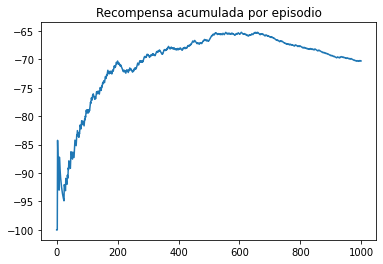

In [41]:
plot_reward_per_episode(reward_epQL_1)

### Graficamos los resultados obtenidos para el algoritmo **SARSA** y sus distintos parámetros. 

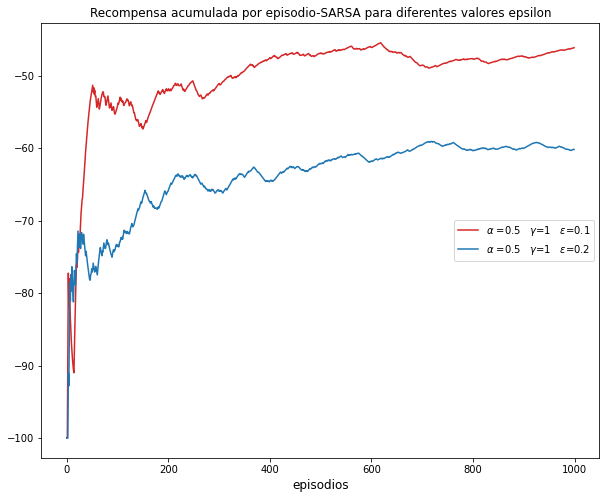

In [42]:
fig = plt.figure(figsize=(10,8))
ax = fig.subplots(1,1)
ax.plot(reward_per_episode(reward_epSARSA), 
        color = 'tab:red', 
        label=r'$\alpha$ =0.5   $\gamma$=1   $\epsilon$=0.1')
ax.plot(reward_per_episode(reward_epSARSA_1), color = 'tab:blue', 
        label=r'$\alpha$ =0.5   $\gamma$=1   $\epsilon$=0.2')
ax.legend(loc = 'right')
plt.title('Recompensa acumulada por episodio-SARSA para diferentes valores epsilon')
plt.xlabel("episodios", size = 12)
plt.show()


### Graficamos los resultados obtenidos para el algoritmo **QLearn** y sus distintos parámetros. 

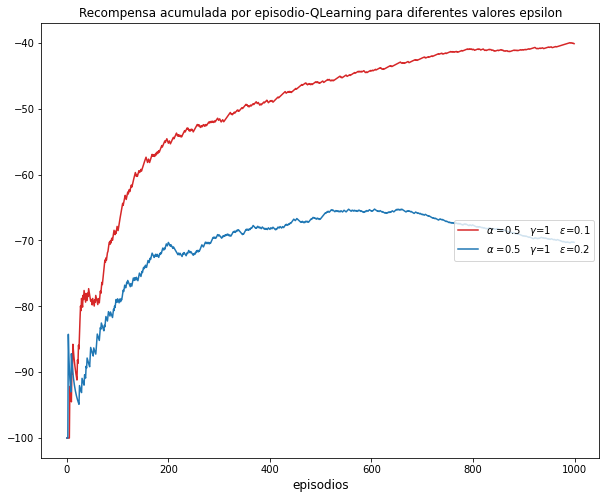

In [43]:
fig = plt.figure(figsize=(10,8))
ax = fig.subplots(1,1)
ax.plot(reward_per_episode(reward_epQL), 
        color = 'tab:red', 
        label=r'$\alpha$ =0.5   $\gamma$=1   $\epsilon$=0.1')
ax.plot(reward_per_episode(reward_epQL_1), color = 'tab:blue', 
        label=r'$\alpha$ =0.5   $\gamma$=1   $\epsilon$=0.2')
ax.legend(loc = 'right')
plt.title('Recompensa acumulada por episodio-QLearning para diferentes valores epsilon')
plt.xlabel("episodios", size = 12)
plt.show()


En las gráficas precedentes observamos que para ambos algoritmos, la recompensa acumulada por episodio aumenta progresivamente con el tiempo y se nivela en un valor alto de recompensa por episodio para los casos en que el valor de $\epsilon$=0.1. Es decir que para acciones exploratorias del 10% se obtuvo una mejor perfomance que para una exploración aleatoria del 20%. 

In [44]:
env.close()

**b. Analizamos diferentes valores de $\epsilon$ y $\gamma$.**

In [45]:
q = {}

alpha = 0.5 # Queda igual que los anteriores
gamma = 0.8 # Antes 1
epsilon = 0.1 

episodes_to_run = 1000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [46]:
def runSARSA_2():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        #action = random_state.choice(actions)
        
        while not done:
            #env.render()

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state)
            #next_action = random_state.choice(actions)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learnSARSA(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learnSARSA(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [47]:
# Creamos el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# Definimos los híper-parámetros básicos según lo observado en clase

alpha = 0.5
gamma = 0.8
epsilon = 0.1

episodes_to_run = 1000

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

In [48]:
def runQL_2():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = choose_action(state)
        #action = random_state.choice(actions)
        
        while not done:
            #env.render()

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = choose_action(state)
            #next_action = random_state.choice(actions)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learnQLEARN(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learnQLEARN(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [49]:
# Ejecutamos los agentes
_, _, reward_epSARSA_2 = runSARSA_2()
_, _, reward_epQL_2 = runQL_2()

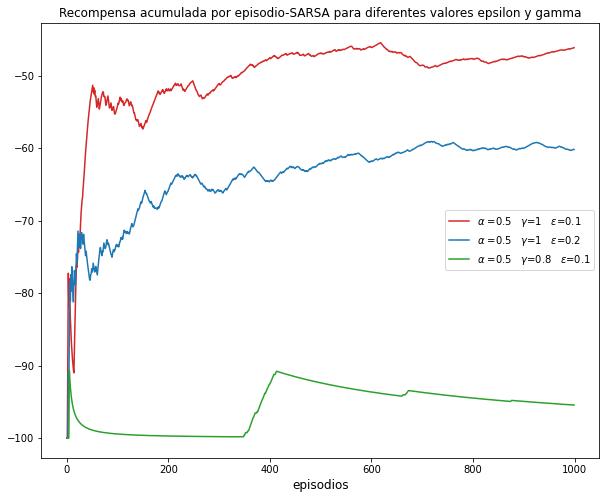

In [50]:
# Gráfico comparativo SARSA
fig = plt.figure(figsize=(10,8))
ax = fig.subplots(1,1)
ax.plot(reward_per_episode(reward_epSARSA), 
        color = 'tab:red', 
        label=r'$\alpha$ =0.5   $\gamma$=1   $\epsilon$=0.1')
ax.plot(reward_per_episode(reward_epSARSA_1), color = 'tab:blue', 
        label=r'$\alpha$ =0.5   $\gamma$=1   $\epsilon$=0.2')
ax.plot(reward_per_episode(reward_epSARSA_2), color = 'tab:green', 
        label=r'$\alpha$ =0.5   $\gamma$=0.8   $\epsilon$=0.1')
ax.legend(loc = 'right')
plt.title('Recompensa acumulada por episodio-SARSA para diferentes valores epsilon y gamma')
plt.xlabel("episodios", size = 12)
plt.show()

En la gráfica precedente para el algoritmo SARSA, observamos que la recompensa acumulada difiere según la combinación de hiperparámetros. Al enfocarnos en el valor del factor de descuento $\gamma$, se destaca que su reducción desde 1 a 0.8, empeoró sustancialmente la recompensa acumulada.

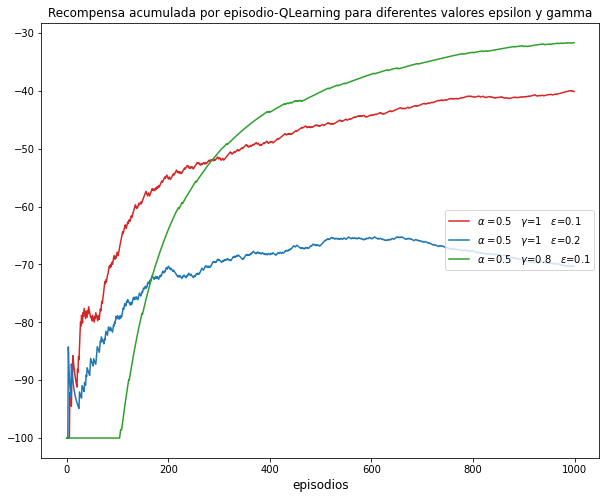

In [51]:
# Gráfico comparativo QLearn
fig = plt.figure(figsize=(10,8))
ax = fig.subplots(1,1)
ax.plot(reward_per_episode(reward_epQL), 
        color = 'tab:red', 
        label=r'$\alpha$ =0.5   $\gamma$=1   $\epsilon$=0.1')
ax.plot(reward_per_episode(reward_epQL_1), color = 'tab:blue', 
        label=r'$\alpha$ =0.5   $\gamma$=1   $\epsilon$=0.2')
ax.plot(reward_per_episode(reward_epQL_2), color = 'tab:green', 
        label=r'$\alpha$ =0.5   $\gamma$=0.8   $\epsilon$=0.1')
ax.legend(loc = 'right')
plt.title('Recompensa acumulada por episodio-QLearning para diferentes valores epsilon y gamma')
plt.xlabel("episodios", size = 12)
plt.show()

En la gráfica precedente observamos que la recompensa acumulada difiere según la combinación de hiperparámetros. Al enfocarnos en el valor del factor de descuento $\gamma$, se destaca que su reducción desde 1 a 0.8, mejora sustancialmente la recompensa acumulada.  

###**4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad** $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$


En la política de exploración Softmax el agente selecciona los movimientos en proporción al conocimiento que tiene en cada momento de su recompensa esperada. Sólo selecciona aquellos movimientos con mayor probabilidad.

In [ ]:
import math
def softmax_choose_action(state):
    """
    Chooses an action according to the learning previously performed 
    using an softmax exploration policy
    """
    q_values = [q.get((state, a), 0.0) for a in actions]
    values_exp = [math.exp(v/tau) for v in q_values]
    
    #while values_exp !=0:
    sum_exp = sum(values_exp)
    if sum_exp==0:
      print(sum_exp)
    
    softmax = [v/sum_exp for v in values_exp]
    #Find the number that is closest to the random generated value
    cum_sum_softmax = np.cumsum(softmax)
    n = random_state.uniform()
    for i in range(len(actions)):
        if cum_sum_softmax[i] >= n:
            action = actions[i]
            break
            
    
    return action
 

###Implementamos la política Sofmax para algoritmo Sarsa

Para este algoritmo utilizamos los parámtros alpha y gama

In [ ]:
# Creamos el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5# Antes 0.5
gamma = 0.8 # Antes 1
tau = 20

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)


In [ ]:
#SARSA CON POLITICA SOFTMAX
def runSARSA_SF():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = softmax_choose_action(state)
        #action = random_state.choice(actions)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = softmax_choose_action(state)
            #next_action = random_state.choice(actions)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learnSARSA(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learnSARSA(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [ ]:
# Ejecutamos el agente
avg_steps_per_episode, timesteps_ep, reward_epSARSA_SF = runSARSA_SF()

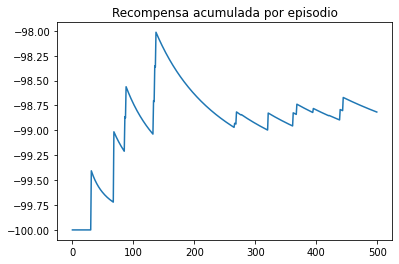

In [ ]:
plot_reward_per_episode(reward_epSARSA_SF)

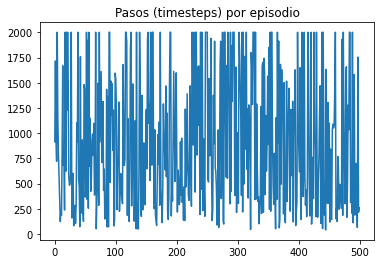

In [ ]:
# Ploteamos el reward para cada episodio
plot_steps_per_episode(timesteps_ep)

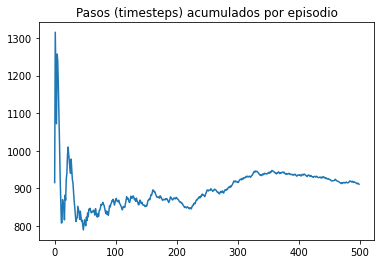

In [ ]:
#Graficamos pasos acumulados por episodio
plot_steps_per_episode_smooth(timesteps_ep)

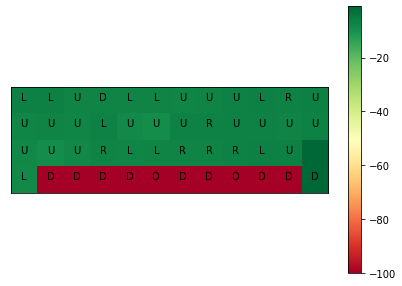


 Matriz de mejor acción-valor (en números): 

 [[  -6.32356076   -6.32800586   -7.0490364    -7.04470388   -6.86084894
    -6.94935889   -7.56164486   -6.87736483   -6.55894764   -6.29190115
    -6.65640634   -6.26767487]
 [  -7.49813779   -6.98465935   -7.20079283   -6.72304252   -8.01596565
    -9.11610718   -6.54493689   -6.57253044   -6.58595831   -6.67628012
    -7.17226524   -6.69197278]
 [  -7.62419244   -8.90152383   -7.65186039   -6.9499688    -7.35729874
    -6.93001302   -7.16958453   -6.86117737   -6.66243183   -6.40970452
    -6.39653989   -1.        ]
 [  -8.22022517 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [ ]:
#Graficamos matriz acción-valor
draw_value_matrix(q)

###Implementamos la política Sofmax para el algoritmo Q-Learning 

In [ ]:
# Creamos el diccionario que contendrá los valores de Q para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos

alpha = 0.5# Antes 0.5
gamma = 0.8 # Antes 1
tau = 20

episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


In [ ]:
def runQL_SF():
    """
    Runs the reinforcement learning agent with a given configuration.
    """
    # list that contains the amount of time-steps of the episode. It is used as a way to score the performance of
    # the agent.
    timesteps_of_episode = []
    # list that contains the amount of reward given to the agent in each episode
    reward_of_episode = []

    for i_episode in range(episodes_to_run):
        # an instance of an episode is run until it fails or until it reaches 200 time-steps

        # resets the environment, obtaining the first state observation
        state = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # Pick an action based on the current state
        action = softmax_choose_action(state)
        #action = random_state.choice(actions)
        
        while not done:

            # Execute the action and get feedback
            next_state, reward, done, info = env.step(action)
            
            next_action = softmax_choose_action(state)
            #next_action = random_state.choice(actions)
            
            episode_reward += reward

            if not done and t < 2000:  # if the algorithm does not converge, it stops after 2000 timesteps
                learnQLEARN(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            else:
                done = True  # done is ensured to be True (in the case the algorithm did not reach convergence)
                learnQLEARN(state, action, reward, next_state, next_action)
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(reward_of_episode, max(episode_reward, -100))

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

In [ ]:
# Ejecutamos el agente
avg_steps_per_episode, timesteps_ep, reward_epQL_SF = runQL_SF()

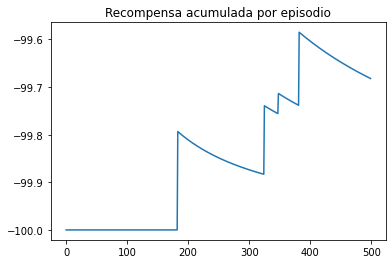

In [ ]:
# Graficamos el reward a lo largo de los episodios en forma acumulada
plot_reward_per_episode(reward_epQL_SF)

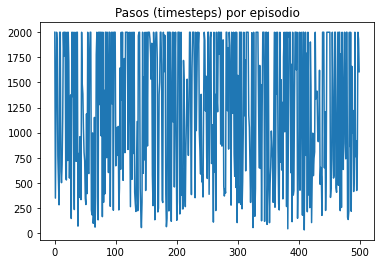

In [ ]:
# Ploteamos el reward para cada episodio
plot_steps_per_episode(timesteps_ep)

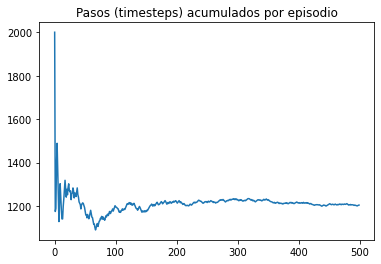

In [ ]:
#Graficamos pasos acumulados por episodio
plot_steps_per_episode_smooth(timesteps_ep)

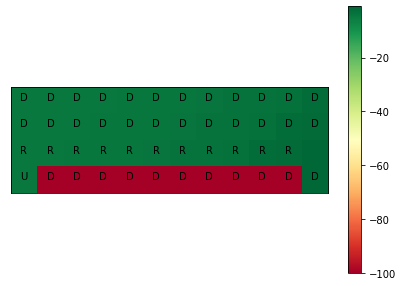


 Matriz de mejor acción-valor (en números): 

 [[  -4.78009767   -4.72512209   -4.65640262   -4.57050327   -4.46312909
    -4.32891136   -4.1611392    -3.951424     -3.68928      -3.3616
    -2.952        -2.44      ]
 [  -4.72512209   -4.65640262   -4.57050327   -4.46312909   -4.32891136
    -4.1611392    -3.951424     -3.68928      -3.3616       -2.952
    -2.44         -1.8       ]
 [  -4.65640262   -4.57050327   -4.46312909   -4.32891136   -4.1611392
    -3.951424     -3.68928      -3.3616       -2.952        -2.44
    -1.8          -1.        ]
 [  -4.72512209 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [ ]:
#Graficamos matriz acción-valor
draw_value_matrix(q)

### **Comparación de recompensas acumuladas para ambos algoritmos con política Softmax**

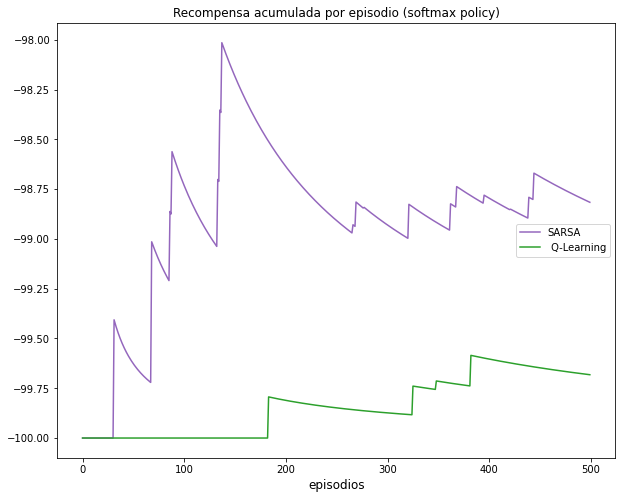

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.subplots(1,1)
ax.plot(reward_per_episode(reward_epSARSA_SF), color = 'tab:purple', label="SARSA")
ax.plot(reward_per_episode(reward_epQL_SF), color = 'tab:green', label=" Q-Learning")
ax.legend(loc = 'right')
plt.title('Recompensa acumulada por episodio (softmax policy)')
plt.xlabel("episodios", size = 12)
plt.show()

Observamos que aplicando la política Softmax, se obtiene una mejor perfomance con el algoritmo SARSA. Es decir se llega a una solución más óptima.
Al analizar las matrices de acción-valor respectivas, vemos que sus valores son muy cercanos entre sí, indicando esto que las recompensas acumuladas se alcanzan casi al mismo tiempo.